In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Warning: Package ReactiveMP does not have ProgressMeter in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added ProgressMeter as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading ProgressMeter into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [6]:
import ReactiveMP.messageout

In [7]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [5]:
### find order
delay_y, delay_u, delay_e = 3, 3, 3
poly_order = 2
order_h = delay_e + 1

output__ = ϕ(randn(sum([delay_y, delay_u, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

41

In [8]:

function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (y, u, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([y; u; h[2:end]])
    end 
end

const phi_ = phi()

#5 (generic function with 1 method)

In [9]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order, seed)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), obs_prec*diageye(h_order)))}
    w  = randomvar()
#     h  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, LeftProposal())}
#     z  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, RightProposal())}
    h  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    AR_meta_1 = ARMeta(Multivariate, h_order, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, full_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_1}
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(phi_, y_prev[t], u[t], seed)}
        ẑ[t] ~ AR(z[t], η, τ) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(dot(ẑ[t], b) + dot(h[t], c), obs_prec)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y_nodes, y
end

narmax (generic function with 1 method)

In [10]:
function narmax_inference(observations, observations_prev, controls; 
                          h_order, full_order,
                          h_prior=(randn(h_order), diageye(h_order)),
                          w_prior=(1.0, 1.0), 
                          η_prior=(zeros(full_order), diageye(full_order)),
                          τ_prior=(1.0, 1.0), vmp_its=10, seed=10, 
                          progress=true)
        
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, z, ẑ, y_nodes, y) = narmax(n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, h_order, full_order, seed,
                                                      options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    z_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    subscribe!(getmarginals(z), (x) -> copyto!(z_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginals!(z, MvNormalMeanPrecision(randn(full_order), diageye(full_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    p = ProgressMeter.Progress(vmp_its)
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
        if progress
            ProgressMeter.next!(p)
        end
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, z_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [11]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

## cascade dataset

In [12]:
df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

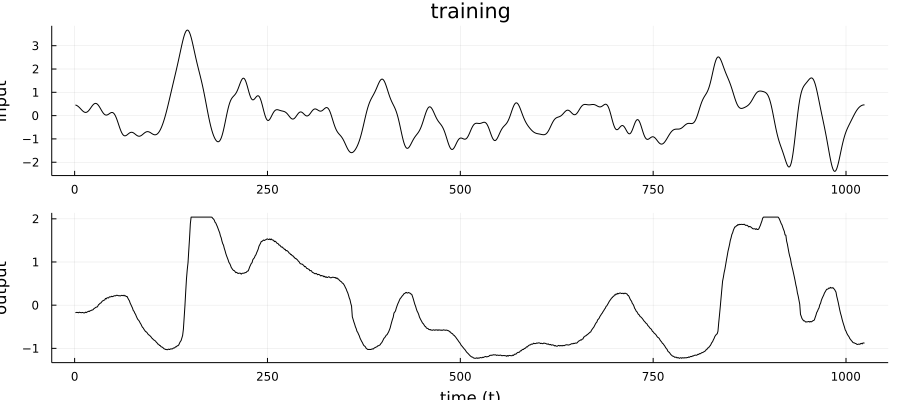

In [13]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

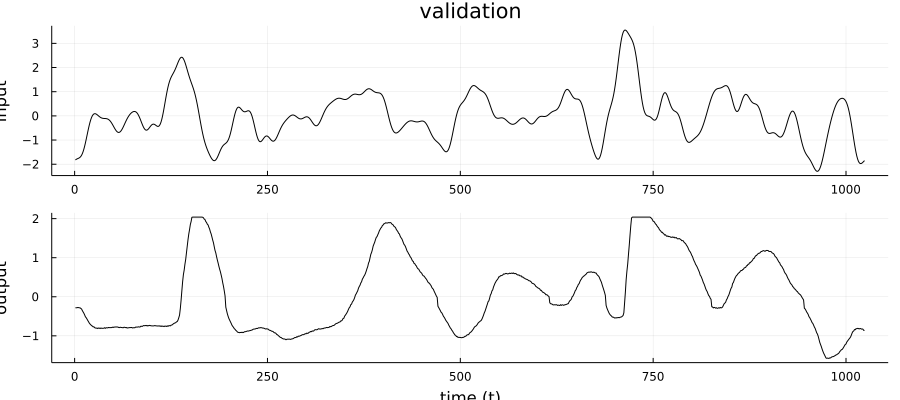

In [14]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## silverbox dataset

In [63]:

# df = DataFrame(CSV.File("../datasets/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# # Select input and output signals
# input = df[:,:V1]
# output = df[:,:V2]

# # Time horizon
# T = length(input);

# # normalization
# input = (input .- mean(input))/std(input)
# output = (output .- mean(output))/std(output);

In [64]:
# # Select training set
# trn = collect(40101:131072)
# input_trn = input[trn]
# output_trn = output[trn]
# T_trn = length(trn);

# # Select validation set
# val = 101:40100
# input_val = input[val]
# output_val = output[val]
# T_val = length(val);

In [65]:
# # Plot every n-th time-point to avoid figure size exploding
# n = 100
# ix = 1:n:T_trn

# # Plot training signals
# p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
# p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
# p1 = plot(p1a, p1b, layout=(2,1))

In [66]:
# n = 1
# ix = 1:n:1024

# # Plot validation signals
# p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
# p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
# p1 = plot(p1a, p1b, layout=(2,1))

### prepare training/test sets 

In [15]:
train_size = 1000
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [16]:
include("../helpers/ar_extension.jl")

In [17]:
include("../helpers/nonlinear_node.jl")

In [18]:
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_silverbox_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");

In [19]:
coefs_mean = zeros(full_order); 
coefs_precision = diageye(full_order)

sampling_seed = 1
fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = narmax_inference(Y_train, X_train, U_train, h_order=order_h, full_order=full_order,
                                                       h_prior=(zeros(order_h), diageye(order_h)),
                                                       w_prior=(1.0, var(Y_test)), 
                                                       η_prior=(zeros(full_order), diageye(full_order)),
                                                       τ_prior=(1e2, 1.0), vmp_its=100, seed=sampling_seed);



Progress: 100%|█████████████████████████████████████████| Time: 0:04:16


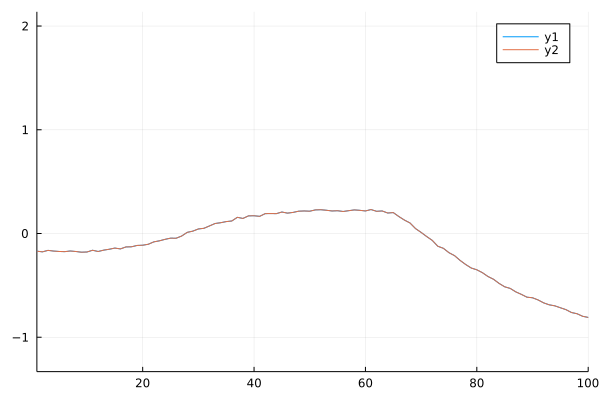

In [20]:
mfrom, mto = 1, 100
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

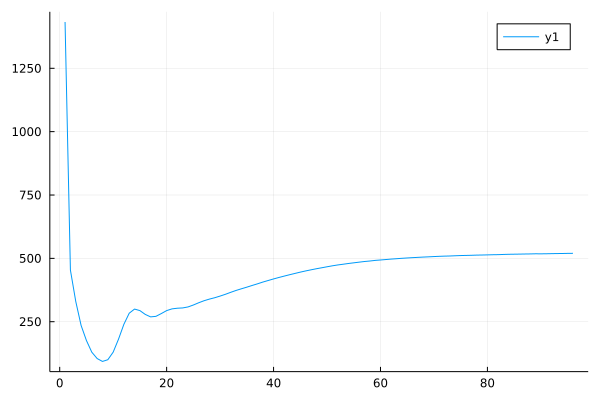

In [21]:
plot(fe_[5:end])

In [72]:
JLD.save("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld", "η_", η_, "τ_", τ_, "w_", w_, "h_", h_, "fe_", fe_)

In [22]:
mean(τ_)

148.1097388950968

In [23]:
mean(w_)

35.66677403123061

In [24]:
mean(η_)

41-element Vector{Float64}:
 0.04159690543743383
 0.023873250189388042
 0.041618635738572676
 0.02394515405450994
 0.02404154535025157
 0.04147298360946202
 0.023934510727795746
 0.024052001849452973
 0.024082285256260726
 0.006316930923952456
 0.0038670072794818504
 0.0036912912461576934
 0.003506977962641168
 ⋮
 0.005762916743227212
 0.005543568750080394
 0.0014872529180949869
 0.002154603679507678
 0.0027964655893250364
 0.0034079336482258312
 1.3322831835850089
 0.0001543367610754374
 1.8880459729561168
 0.00015456129500456215
 1.3290358617656113
 0.00015185532349537288

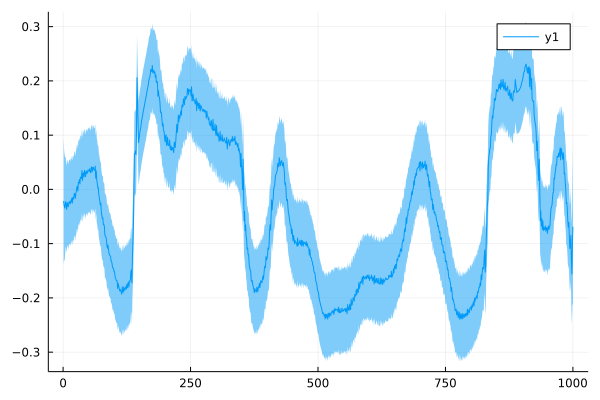

In [25]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction 

In [26]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [27]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, 42))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

prediction (generic function with 1 method)

In [28]:
τ_ = GammaShapeRate(shape(τ_), rate(τ_))

GammaShapeRate{Float64}(a=600.0, b=4.051050285254828)

In [29]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
    push!(predictions, pred)
    fe_, h_post, θ_post, w_post, η_post, τ_post, _, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                         h_prior=(mean(h_prior), precision(h_prior)),
                                                                         w_prior=(shape(w_prior), rate(w_prior)), 
                                                                         η_prior=(mean(η_), precision(η_)),
                                                                         τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


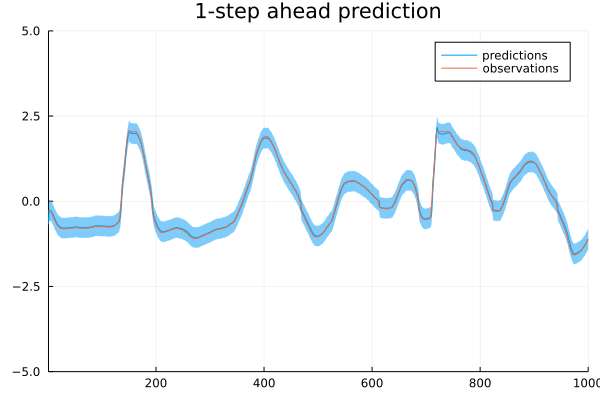

In [30]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 1000), ylims=(-5, 5), title="1-step ahead prediction", label="observations")

In [31]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.046005694793432306

In [100]:
# naive simulation setting

In [32]:
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

simulated_mean = -0.3ones(length(X_test))
simulated_var = ones(length(X_test))
ProgressMeter.@showprogress for i in delay_y:length(Y_test)
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, simulated_mean[i-delay_y+1:i], U_test[i], full_order=full_order, h_order=order_h)
    simulated_mean[i] = mean(pred_sim)
    simulated_var[i]  = cov(pred_sim)
    
     _, h_post, θ_post, w_post, η_post, τ_post, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                         h_prior=(mean(h_prior), precision(h_prior)),
                                                                         w_prior=(shape(w_prior), rate(w_prior)), 
                                                                         η_prior=(mean(η_), precision(η_)),
                                                                         τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


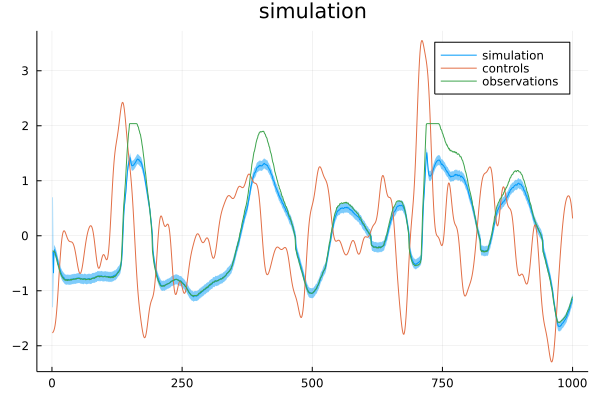

In [33]:
from, to = 1, 1000
plot(simulated_mean[from:to],  ribbon=simulated_var[from:to], label="simulation")
plot!(first.(U_test[from:to]), label="controls")
plot!(Y_test[from:to], title="simulation", label="observations")

In [34]:
RMSE = sqrt(mean((simulated_mean[from:to] .- Y_test[from:to]).^2))

0.23490641969475556